In [15]:
import theano
import theano.tensor as T
import theano.tensor.nnet as nnet
import numpy as np
import time

import cv2 
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
import time
from math import sqrt
from skimage import transform
import skimage 

In [55]:
def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

In [56]:
M2 = cv2.imread("./training/preprocess/img0_M2.jpg", 0)
combine = cv2.imread("./training/preprocess/img0_combined.jpg", 0)

In [134]:
combine1 = combine / 255

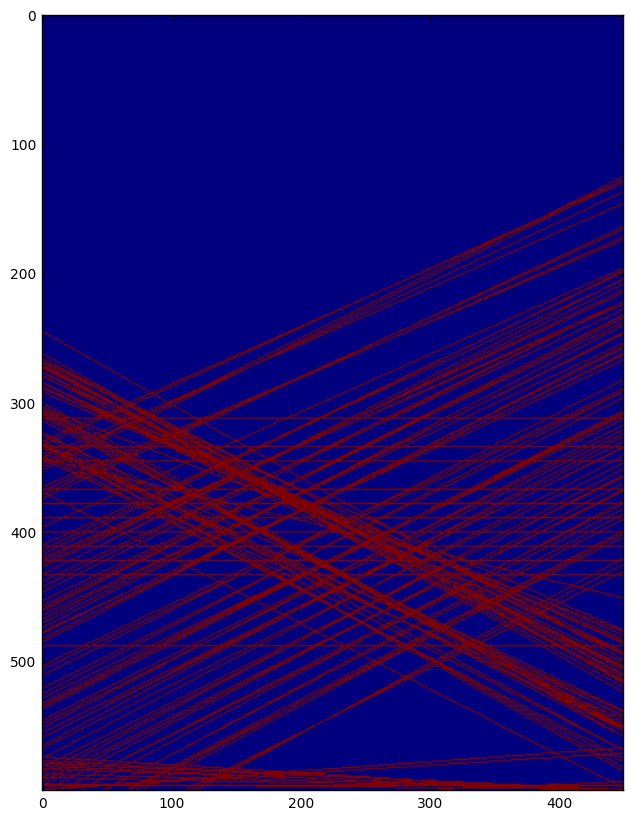

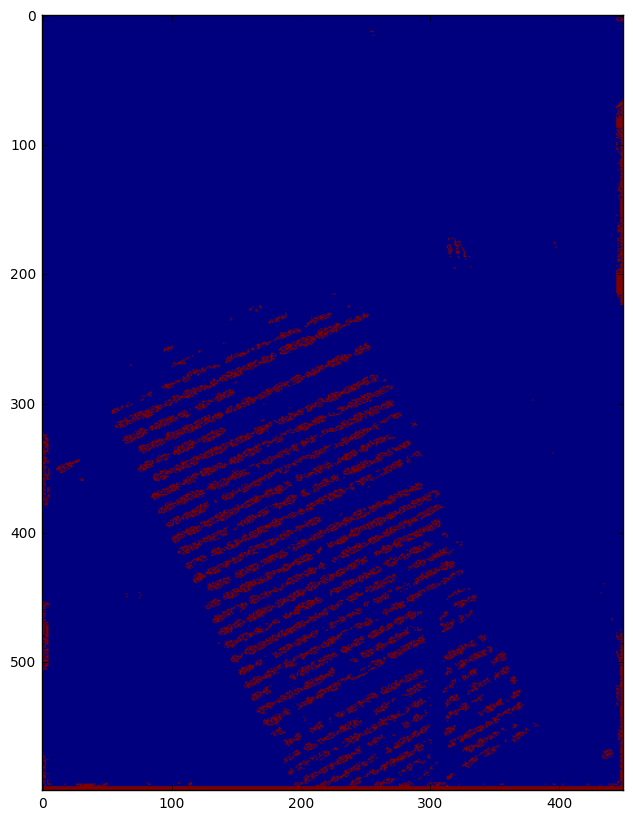

In [131]:


def findLines(maxAngl, minAngl, img):
    lines = cv2.HoughLines(img, rho = 1.1, theta = np.pi/360, threshold = 90)
    empty = np.ones((600, 450))
    output = []
    
    for item in lines:
        for rho, theta in item:
            if theta < maxAngl and theta > minAngl:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(empty,(x1,y1),(x2,y2),(255,255,255),1)
                output.append([rho, theta])
                
    plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(empty)    
    plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
    plt.imshow(img)
    
    return output
# maxAngl = np.pi/4 + np.pi/8
# minAngl = np.pi/4 - np.pi/8

maxAngl = np.pi/2 + np.pi/6
minAngl = np.pi/2 -np.pi/6
lines = findLines(maxAngl, minAngl, combine1)

In [132]:
# make histogram of lines to find vanishinpoint

